# Context

According to the Mayo Clinic, "[s]noring is the hoarse or harsh sound that occurs when air flows past relaxed tissues in your throat, causing the tissues to vibrate as you breathe. Nearly everyone snores now and then, but for some people it can be a chronic problem."

Snorning can be an indicator of sleep apnea where a person might stop breathing for a certain amount of time during sleep. This may lead to insufficient rest or in the long run, heart problems.

# Problem Statement

The main goal of the project is to build a classifcation model that will detect the prescence of snoring in a sound clip.

We will be using accuracy as our matrix while also looking at the confusion matrix to judge how well it performs with respect to false positives and false negatives.


# Proposed Methods and Models

We will be using the librosa library to convert sound clips of snorning and non-snoring sounds to features, mainly, the Mel-frequency cepstral coefficients (MFCCs). MFCC are widely used in Speech Recognition Tasks and other audio classification problems.

We will then use Classification models (Logistic Regression, K-Nearest Neighbor and Random Forest) to return a prediction.

If computing resources are available, we will also use Tensorflow to run a Convolutional Neural Network.

# Data source and assumptions

The data set used is based on an article by Dr. Tareq Khan whose data set has been uploaded to Kaggle.

T. H. Khan, "A deep learning model for snoring detection and vibration notification using a smart wearable gadget," Electronics, vol. 8, no. 9, article. 987, ISSN 2079-9292, 2019.

https://www.kaggle.com/datasets/tareqkhanemu/snoring

We will be assuming that the data and labeling of the data are accurate.

---

# EDA

## Data Description

Below is the data description for the kaggle data source.

"The dataset contains two folders - one for snoring and the other for non-snoring.

Folder 1 contains snoring sounds. It has total 500 sounds. Each sound is 1 second in duration.
Among the 500 snoring samples, 363 samples consist of snoring sounds of children, adult men and adult women without any background sound. The remaining 137 samples consist of snoring sounds having a background of non-snoring sounds.

Folder 0 contains non-snoring sounds. It has total 500 sounds. Each sound is 1 second in duration.
The 500 non-snoring samples consist of background sounds that might be available near the snorer. Ten categories of non-snoring sounds are collected, and each category has 50 samples. The ten categories are baby crying, the clock ticking, the door opened and closed, total silence and the minor sound of the vibration motor of the gadget, toilet flashing, siren of emergency vehicle, rain and thunderstorm, streetcar sounds, people talking, and background television news."

The one second clips are segments of longer sound clips and labelled by the data provider.

## Loading an audio file

In [1]:
# Install the librosa library for analysing sound
#!pip install librosa 

In [33]:
import librosa
import numpy as np
import pandas as pd
import os
import random
import IPython.display as ipd
import matplotlib.pyplot as plt

In [3]:
audio_path = './data/1/1_0.wav'
x, sample_rate = librosa.load(audio_path)

Loading the file, we get an audio time series in an np array and an integer sample rate.

In [4]:
print(x.shape, sample_rate)

(22050,) 22050


Librosa by default loads audio clips at sample rate of 22KHZ mono.

In [5]:
ipd.Audio(audio_path)

# Visualising Sound

## What snoring looks like

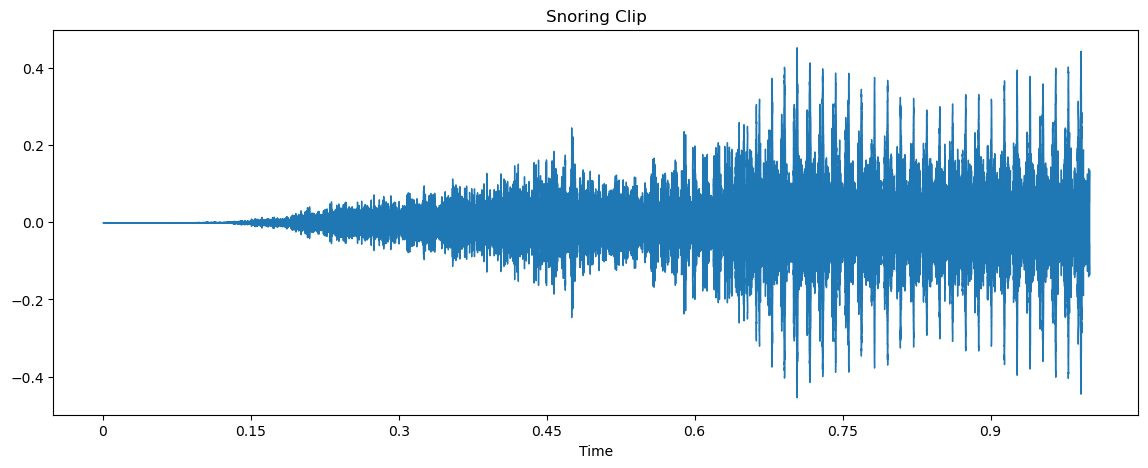

In [6]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14,5))
plt.title('Snoring Clip')
librosa.display.waveshow(x,sr=sample_rate);

We will now use the Short-Time Fourier Transform to visualise the relationship of frequency and intensity of the corresponding sound to time.

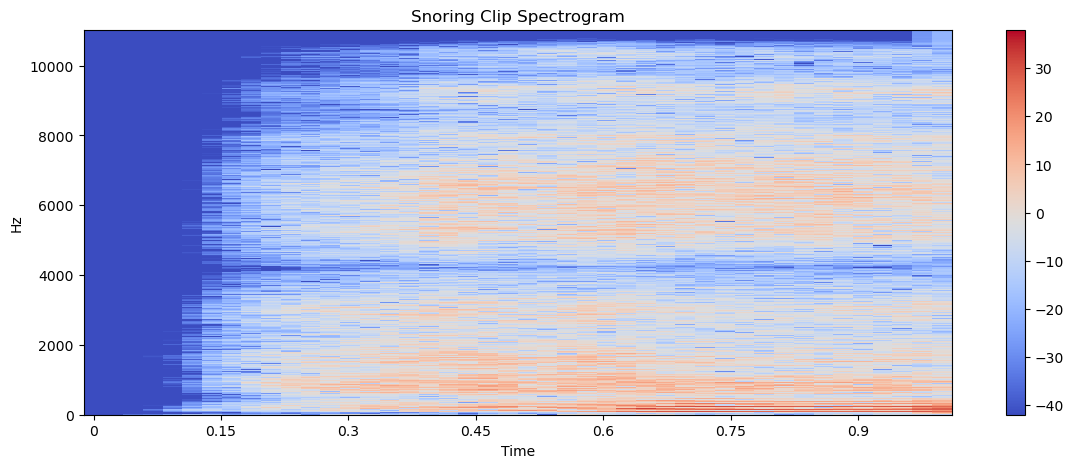

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X)) #calculates the log spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('Snoring Clip Spectrogram')
plt.colorbar();

From this graph, we can see that for snoring, the sounds towards the low frequencies are quite intense especially towards the end. There are also two bands of frequencies which might be characteristic of snoring.

To get a closer visual representation to what humans hear, we usually apply the Mel scale to the above diagram. The Mel scale is a logarithmic scale that closely represents what our ears hear.

Since we will be using the Mel-Frequency Ceptral Coefficients (MFCC) as our features, let's look at what the Mel-Spectrogram looks like.

The MFCC is attained by computing the Discrete Cosine Transform (DCT) on the Mel-Spectrogram. The DCT compresses the values so it would make our models train faster.

In [8]:
mel_spectrogram = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)

In [9]:
mel_spectrogram.shape

(128, 44)

The shape tells us that the frequencies are divided into 128 Mel Bands and into 44 time frames.

The time frames are derived by taking the sample length divided by the hop length.

In this case, since our sample rate is 22050, clip length = 1s and hop length = 512, the number of frames is 
$$(22050\times{1})//512 = 44$$ 

In [10]:
mel_spectrogram

array([[2.64213738e-11, 1.95946612e-07, 5.07036566e-06, ...,
        1.15145016e-02, 1.00284256e-01, 3.15001875e-01],
       [8.99228608e-12, 2.08052136e-08, 1.48117152e-07, ...,
        1.23919907e+01, 1.33915100e+01, 8.77394390e+00],
       [2.19587890e-12, 1.70697501e-08, 9.78863781e-08, ...,
        9.69863281e+01, 9.48856506e+01, 3.64775734e+01],
       ...,
       [4.96435338e-14, 1.17298893e-10, 1.12091458e-09, ...,
        4.90862690e-03, 3.99135333e-03, 3.33545427e-03],
       [3.13740089e-14, 3.16520213e-11, 4.28379499e-10, ...,
        5.29279700e-03, 3.59289185e-03, 1.47264311e-03],
       [5.06067204e-15, 4.07270702e-12, 4.33469684e-11, ...,
        7.16853465e-05, 2.60546629e-04, 9.31344926e-04]], dtype=float32)

In [11]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

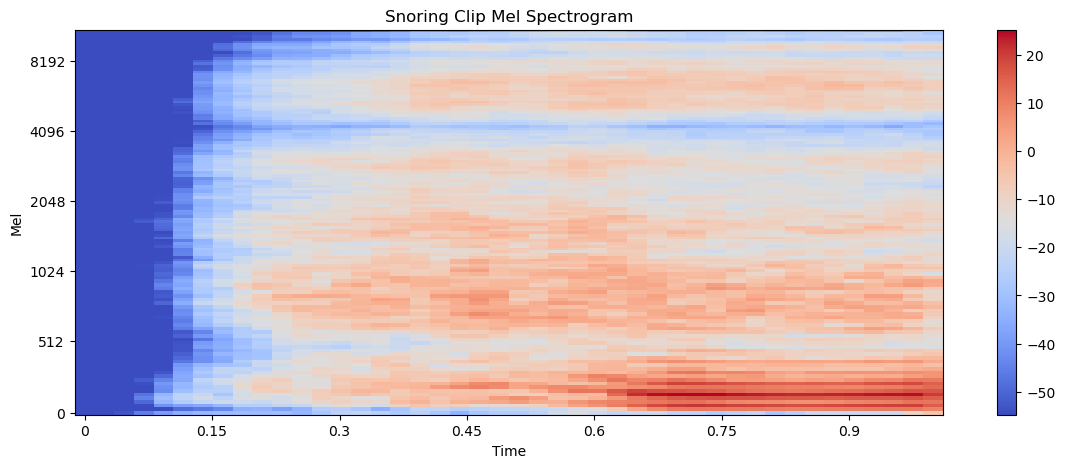

In [12]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Snoring Clip Mel Spectrogram')
plt.xlabel("Time")
plt.ylabel("Mel")
plt.colorbar();

In [13]:
mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=16)

In [14]:
mfccs

array([[-6.19718201e+02, -6.19718201e+02, -6.19556702e+02,
        -6.16063965e+02, -5.96639526e+02, -5.24352844e+02,
        -4.14074493e+02, -3.49256317e+02, -2.94413818e+02,
        -2.51576279e+02, -2.19604706e+02, -2.04657822e+02,
        -1.91587891e+02, -1.77590027e+02, -1.63662659e+02,
        -1.50133667e+02, -1.38638184e+02, -1.25440346e+02,
        -1.18424957e+02, -1.09087318e+02, -1.02140785e+02,
        -1.09087242e+02, -1.20017517e+02, -1.19422302e+02,
        -1.00351372e+02, -8.83216019e+01, -8.73537216e+01,
        -8.48015060e+01, -8.94759293e+01, -9.75388718e+01,
        -9.91041031e+01, -1.01032356e+02, -1.07210556e+02,
        -1.11157021e+02, -1.11786613e+02, -1.09447174e+02,
        -1.11196533e+02, -1.08655693e+02, -1.08716705e+02,
        -1.09176613e+02, -1.08056122e+02, -1.09472809e+02,
        -1.05223114e+02, -1.24738762e+02],
       [ 0.00000000e+00,  0.00000000e+00,  2.28265747e-01,
         4.63806629e+00,  2.50786057e+01,  6.31865616e+01,
         7.43

In [15]:
mfccs.shape

(16, 44)

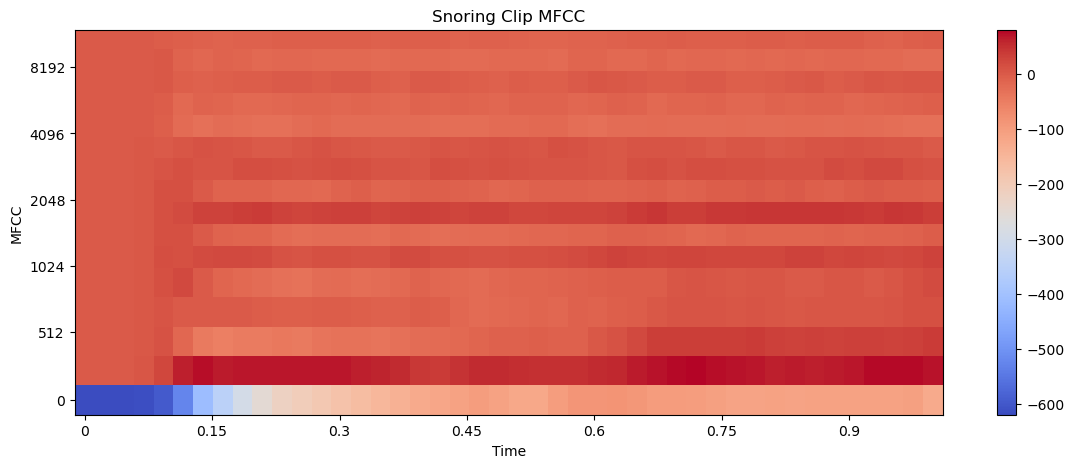

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Snoring Clip MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar();

In [17]:
pd.DataFrame(mfccs)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-619.718201,-619.718201,-619.556702,-616.063965,-596.639526,-524.352844,-414.074493,-349.256317,-294.413818,-251.576279,...,-111.786613,-109.447174,-111.196533,-108.655693,-108.716705,-109.176613,-108.056122,-109.472809,-105.223114,-124.738762
1,0.000000,0.000000,0.228266,4.638066,25.078606,63.186562,74.360756,66.419708,68.957260,67.814102,...,68.618309,64.345329,65.536873,64.703293,65.700821,68.891769,76.356247,77.719269,75.883835,72.313629
2,0.000000,0.000000,0.228214,3.877491,11.985571,-16.222675,-44.087219,-50.651619,-45.977516,-46.482155,...,37.724113,33.067841,29.341999,33.054710,30.606075,32.796856,34.517464,29.443623,33.758480,38.254692
3,0.000000,0.000000,0.228128,3.983415,8.037339,0.455090,0.620752,-0.596887,0.793124,-1.716387,...,7.474118,5.005824,2.628110,6.966086,6.438967,6.236964,5.802529,8.017588,14.974558,15.368725
4,0.000000,0.000000,0.228008,4.498213,13.122451,23.238146,1.200341,-12.896133,-18.834139,-23.415470,...,5.653028,5.218997,0.307756,1.609302,6.307731,4.903334,0.683578,6.667168,13.167959,19.237906
5,0.000000,0.000000,0.227853,4.214556,16.506235,14.899858,18.936687,21.407228,21.201149,18.975584,...,24.048546,24.655087,31.648020,29.493916,25.209419,26.469200,23.755167,22.723698,24.958130,29.841637
6,0.000000,0.000000,0.227664,3.221132,14.609885,12.928682,-0.502200,-10.258217,-12.321943,-12.512782,...,-12.465789,-12.750401,-12.844253,-13.135733,-10.939027,-13.863080,-11.215725,-10.121064,-6.683640,-1.913188
7,0.000000,0.000000,0.227441,2.727710,12.909987,18.450487,30.661663,31.759636,37.070740,39.090721,...,44.247345,43.806015,45.286240,42.886494,45.013176,40.509686,38.760323,43.063225,40.581402,37.370003
8,0.000000,0.000000,0.227184,3.002016,12.897429,13.511889,-0.208725,-11.375477,-9.311916,-10.400816,...,0.067813,-3.109934,-0.442461,-4.363556,-6.902130,-3.620370,-0.871609,-1.351381,-1.840292,-4.145176
9,0.000000,0.000000,0.226892,2.943681,9.100329,13.670135,9.384537,9.683928,17.171963,15.881524,...,13.979843,12.076502,11.770237,12.625326,18.543547,17.767990,21.111717,21.577856,14.684631,10.864752


We can see that the data is organised by 16 features against 44 time frames.
We will need to use the transpose to shape them for our machine learning model.

In [18]:
pd.DataFrame(mfccs.T).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-619.718201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-619.718201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-619.556702,0.228266,0.228214,0.228128,0.228008,0.227853,0.227664,0.227441,0.227184,0.226892,0.226566,0.226206,0.225812,0.225384,0.224922,0.224426
3,-616.063965,4.638066,3.877491,3.983415,4.498213,4.214556,3.221132,2.727710,3.002016,2.943681,2.003797,1.154513,1.242100,1.531929,0.944495,-0.097371
4,-596.639526,25.078606,11.985571,8.037339,13.122451,16.506235,14.609885,12.909987,12.897429,9.100329,0.362565,-5.711589,-3.430825,2.453673,3.376277,-1.909351


In [24]:
np.array(mfccs.T).shape

(44, 16)

To compress our observations to a single time frame for our models, we will take the mean of values across all time frames.

In [25]:
np.mean(mfccs.T,axis=0).shape

(16,)

## Non-snoring

In [52]:
audio_path = './data/0/0_0.wav'
x, sample_rate = librosa.load(audio_path)

In [53]:
ipd.Audio(audio_path)

This is the sound of a baby crying.

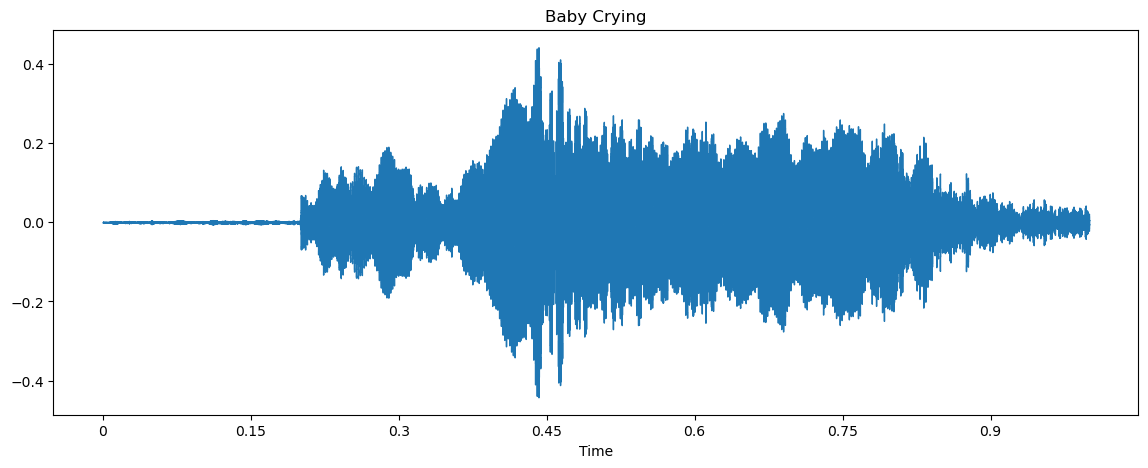

In [54]:
plt.figure(figsize=(14,5))
plt.title('Baby Crying')
librosa.display.waveshow(x,sr=sample_rate);

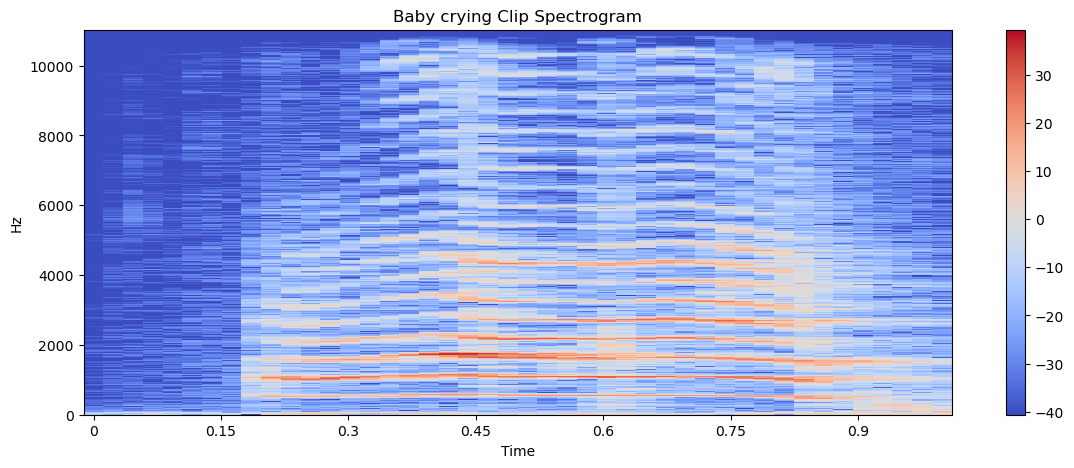

In [55]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('Baby crying Clip Spectrogram')
plt.colorbar();

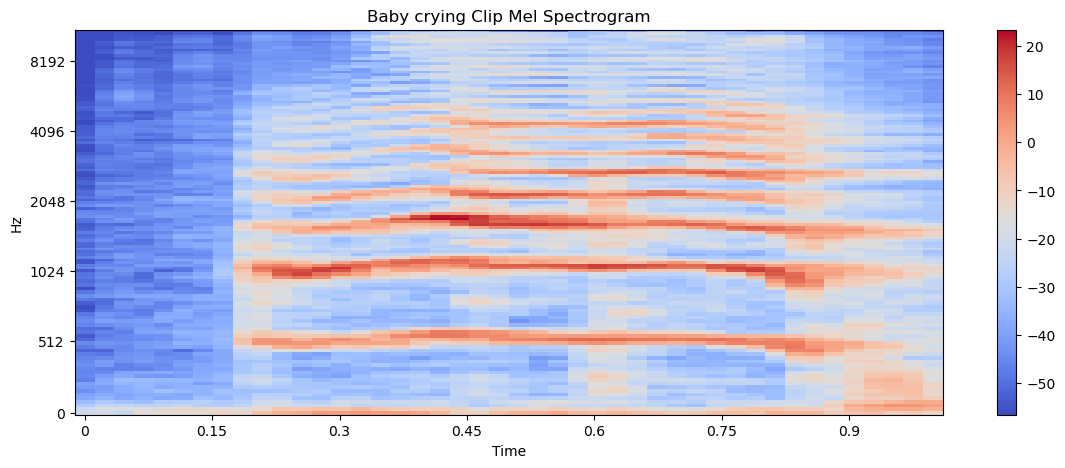

In [56]:
mel_spectrogram = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
plt.figure(figsize=(14, 5))
librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Baby crying Clip Mel Spectrogram')
plt.colorbar();

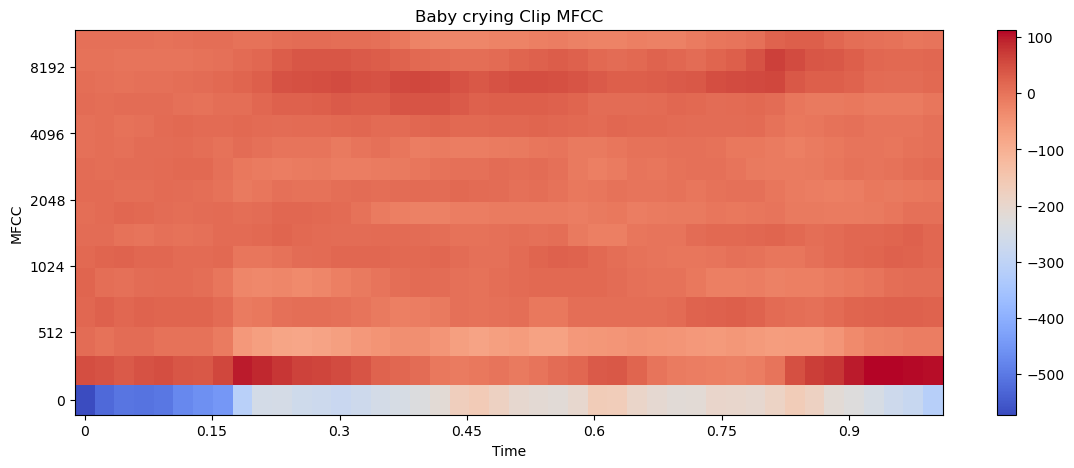

In [58]:
mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=16)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Baby crying Clip MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar();

We can see distinct differences between the MFCC plots of the Baby Crying and Snore.

In the next section, we will compare the MFCC plots of multiple clips.

# Comparing snoring and non-snoring MFCCs

In this section, we will investigate 9 random clips from the snoring data set and the non-snoring data set.

In [77]:
list_of_snores = os.listdir('data/1')
list_of_not_snores = os.listdir('data/0')

In [105]:
random.seed(42)
snore_samples = random.choices(list_of_snores, k=9)
not_snore_samples = random.choices(list_of_not_snores, k=9)

In [106]:
snore_samples

['1_386.wav',
 '1_109.wav',
 '1_221.wav',
 '1_199.wav',
 '1_43.wav',
 '1_402.wav',
 '1_50.wav',
 '1_137.wav',
 '1_288.wav']

In [128]:
def plot_mfccs(list_of_sounds,label):
    for clip in list_of_sounds:
        audio_path = os.path.join('data',str(label),clip)
        x, sample_rate = librosa.load(audio_path)
        mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=16)
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.title('Clip MFCC')
        plt.xlabel("Time")
        plt.ylabel("MFCC")
        plt.colorbar();

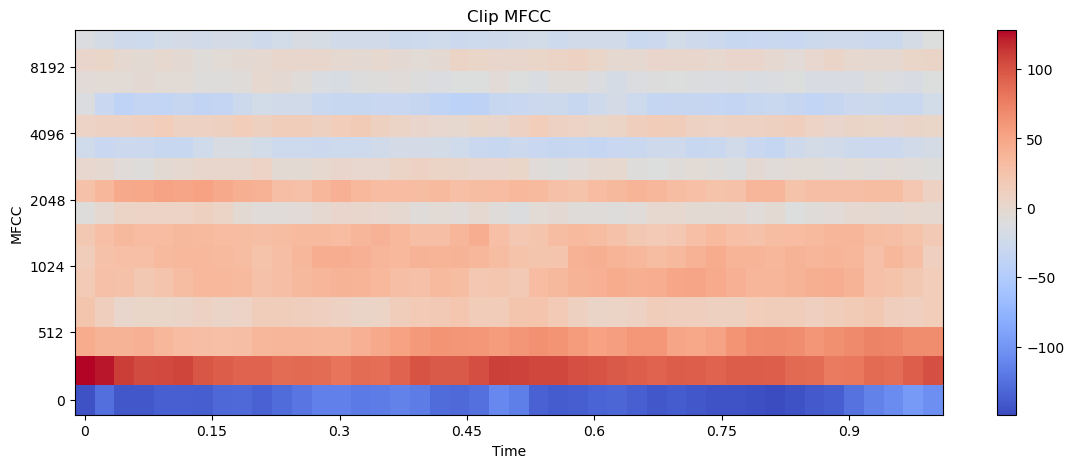

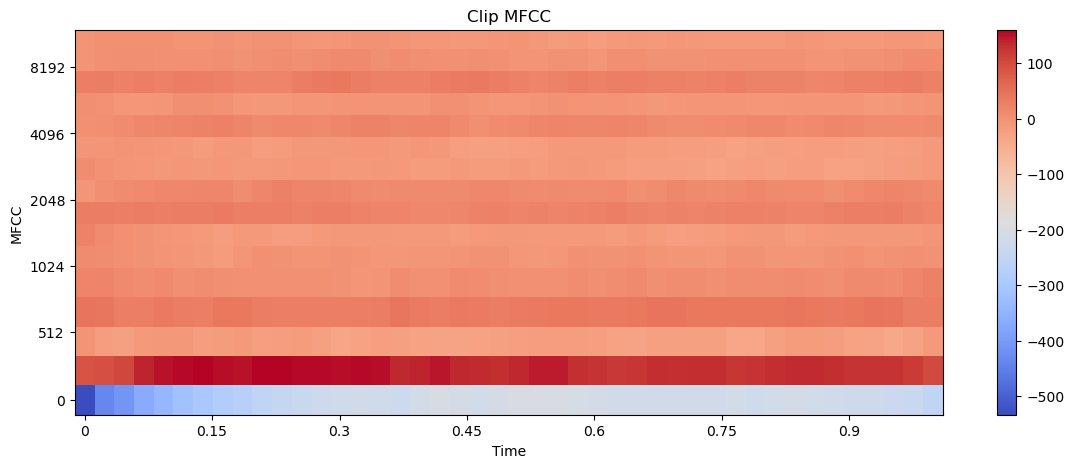

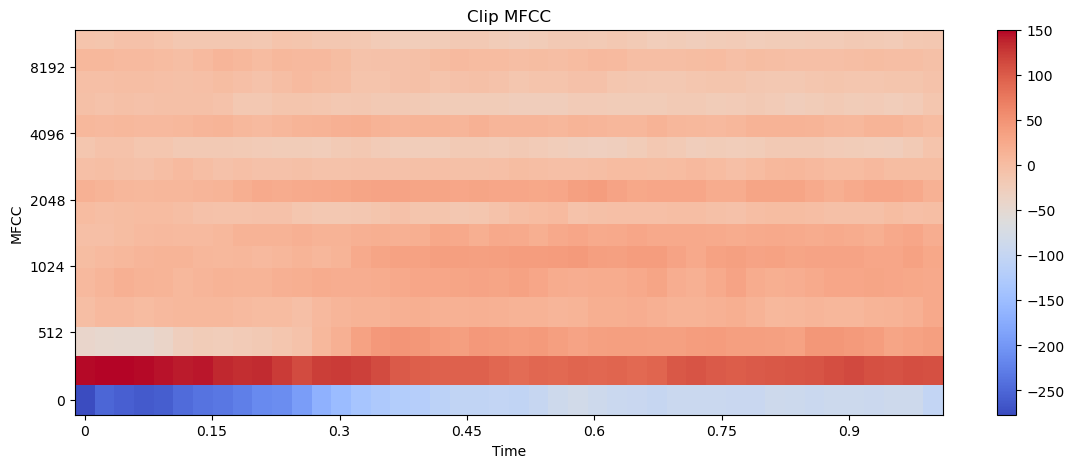

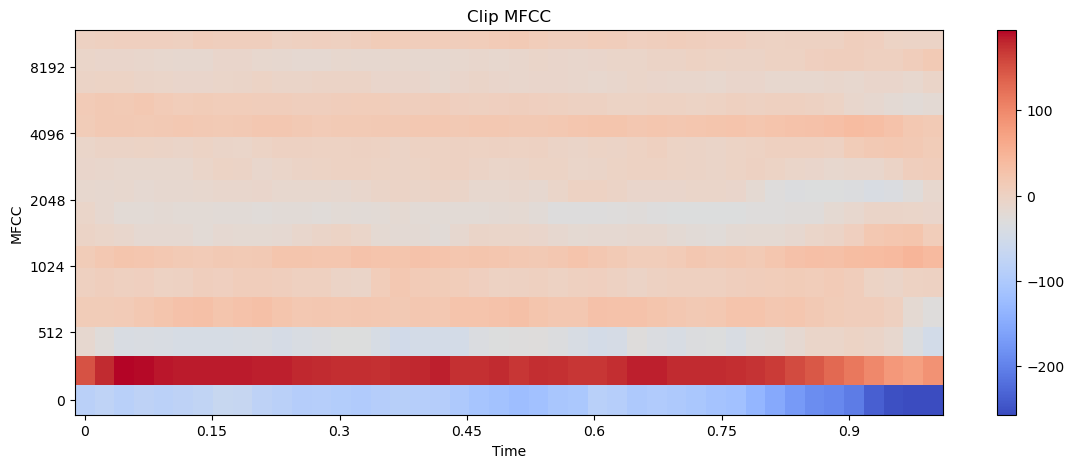

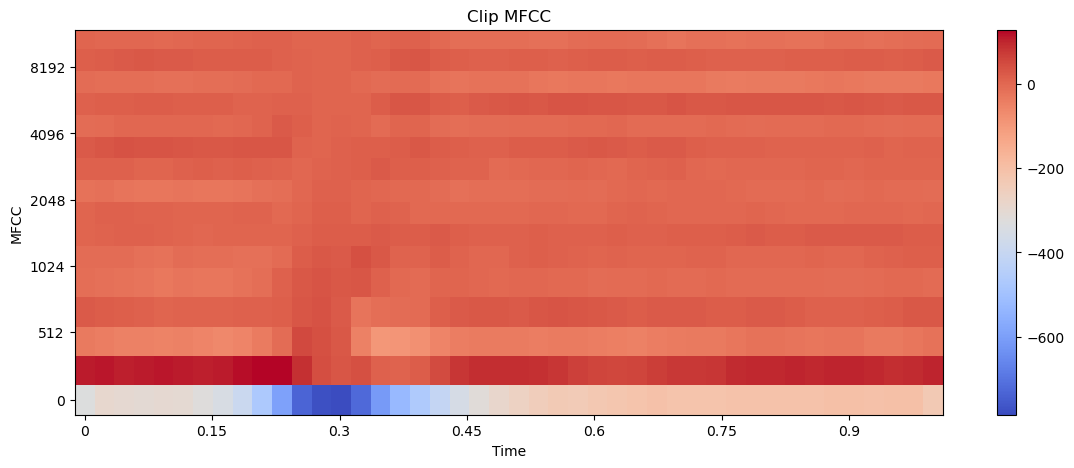

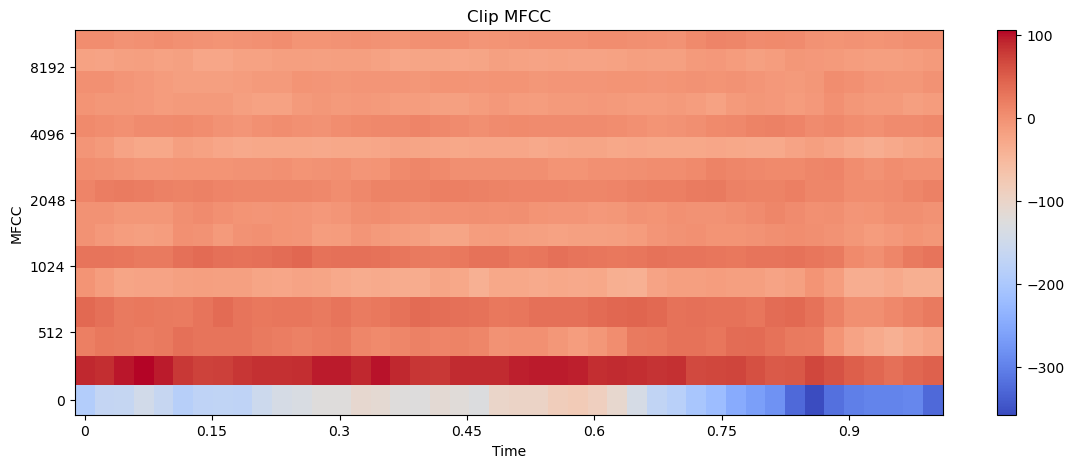

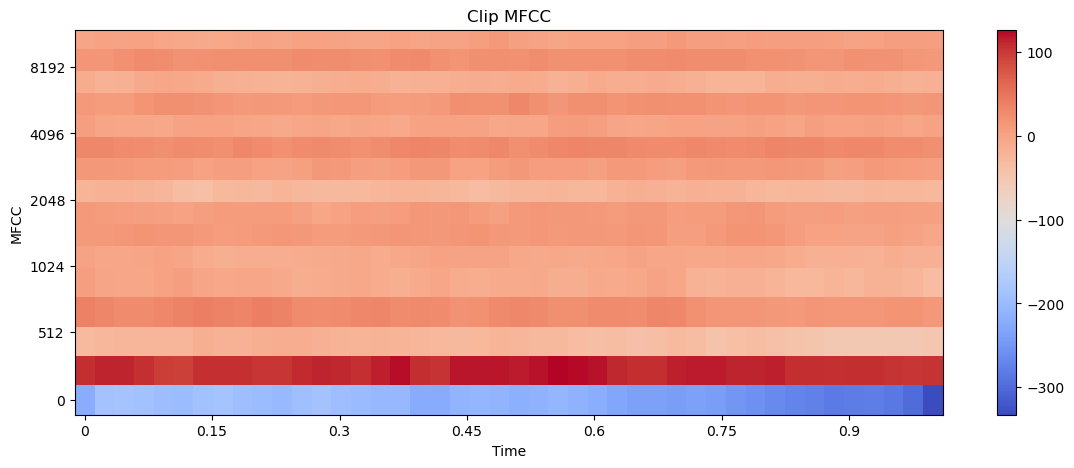

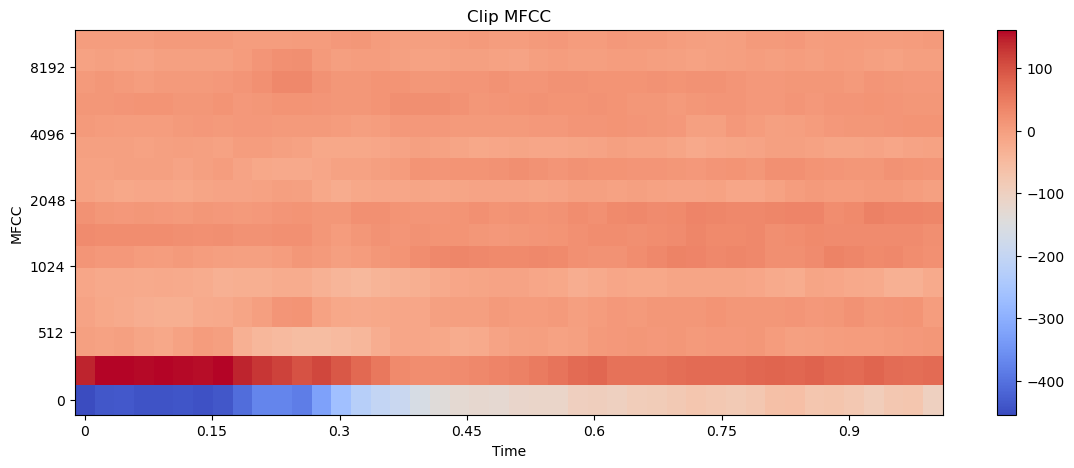

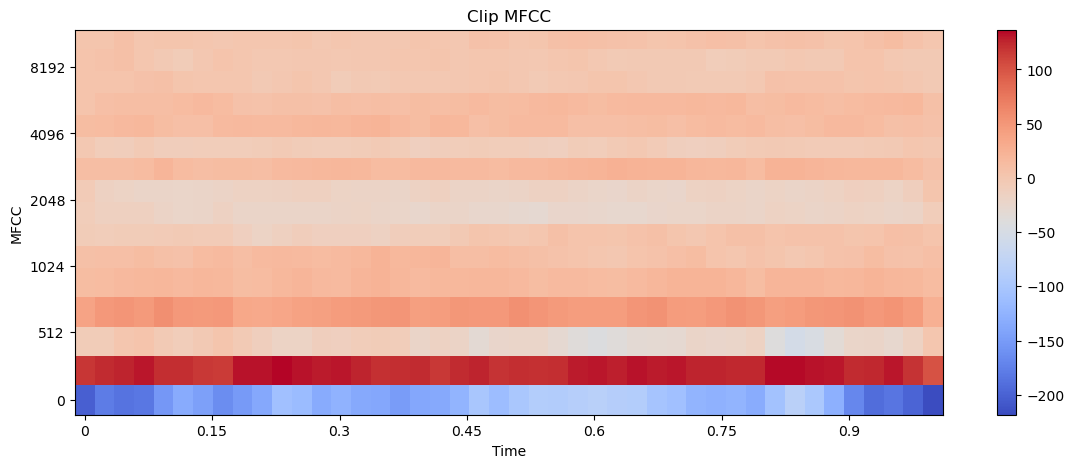

In [129]:
plot_mfccs(snore_samples,1)

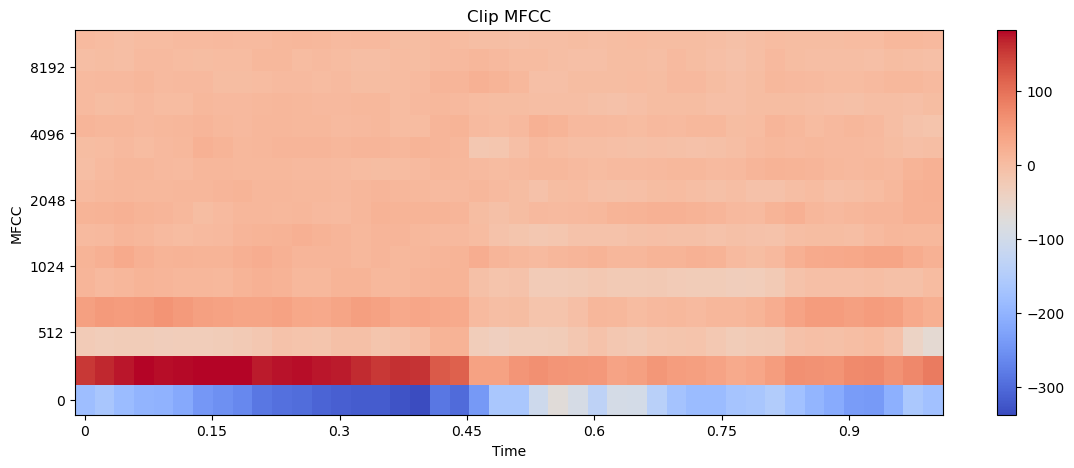

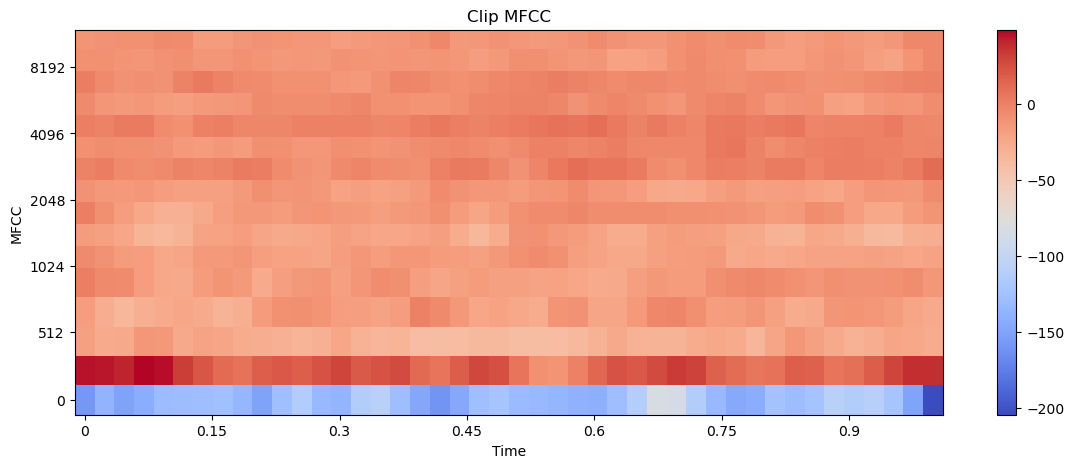

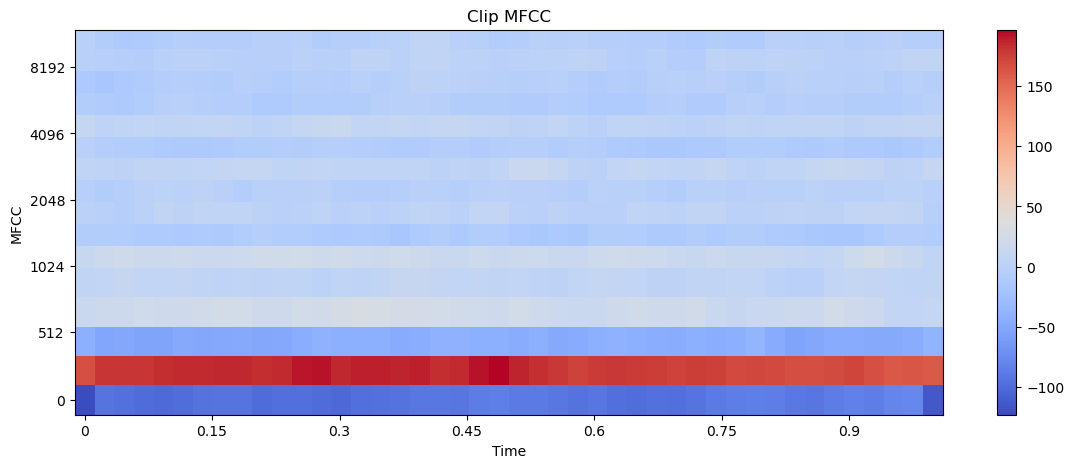

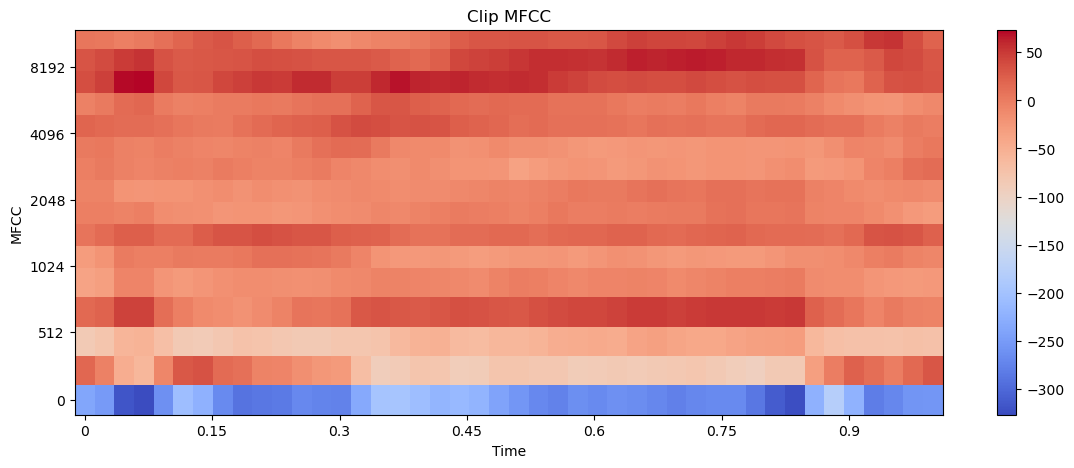

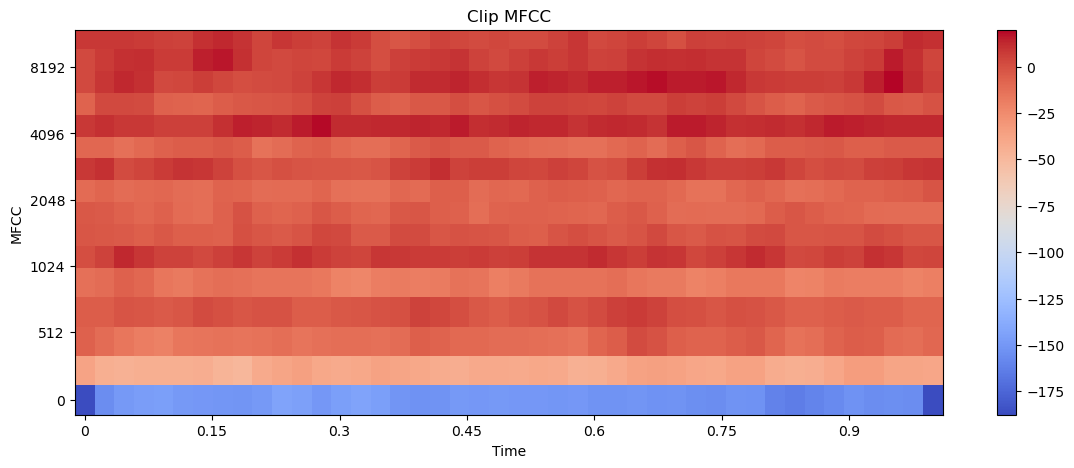

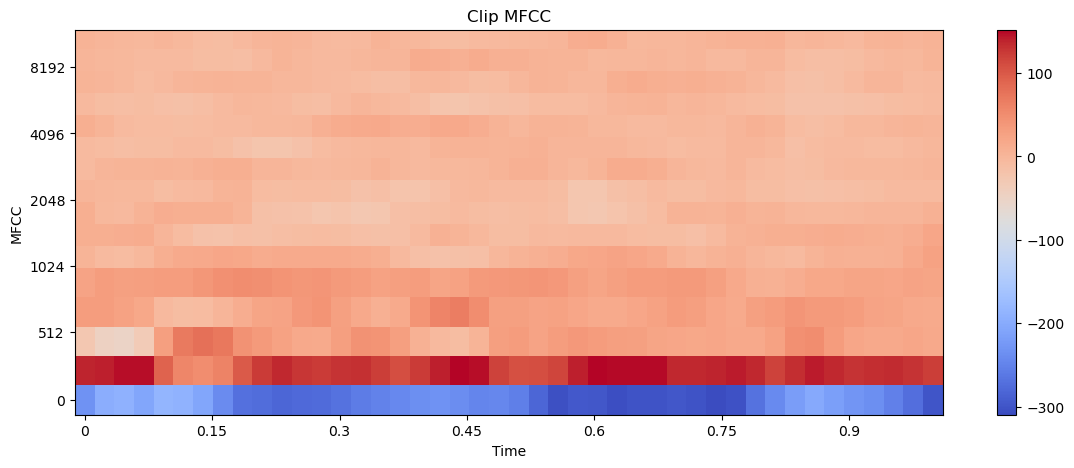

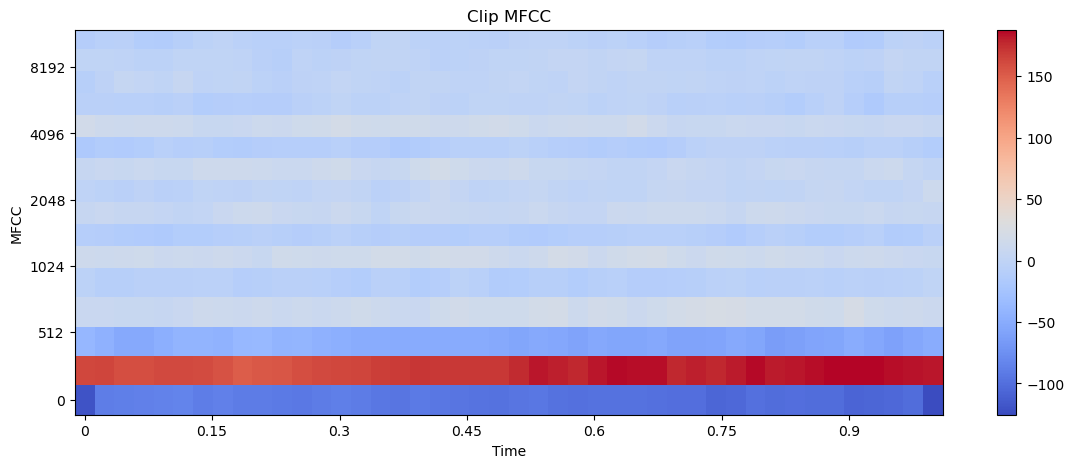

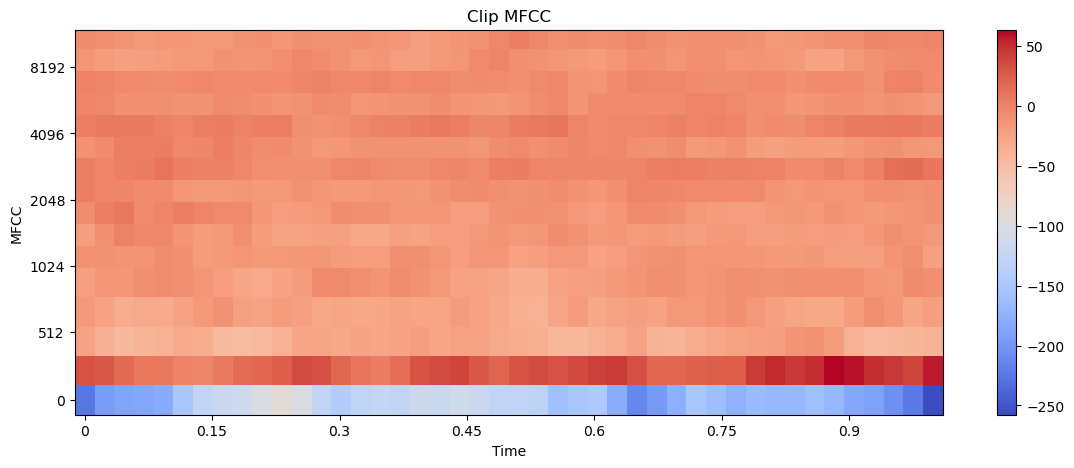

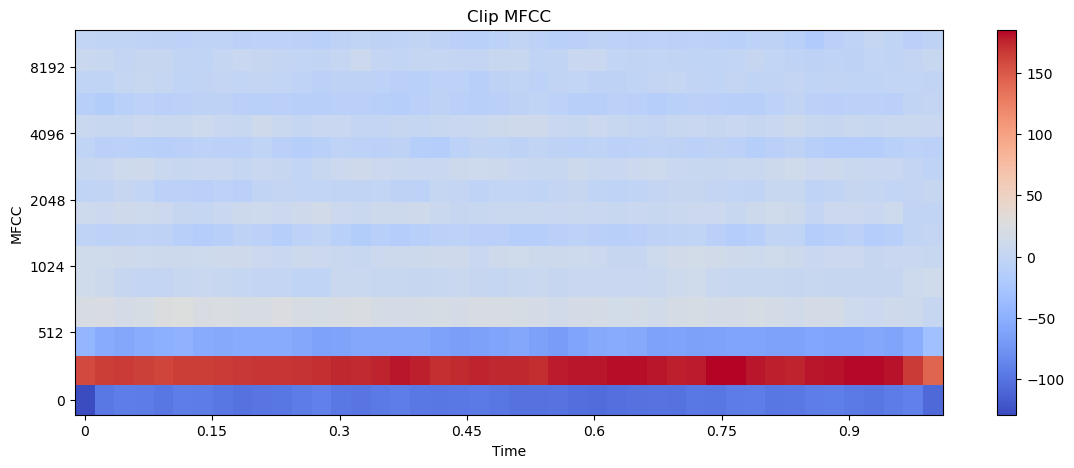

In [130]:
plot_mfccs(not_snore_samples,0)

We can see that for snoring, the intensity is high for the second band and all along the spectrum, we can see that different frequencies intensities are captured.

In the non-snoring samples, we can also see some sounds with a similar sound profile. Let's listen to them.

In [132]:
ipd.Audio(os.path.join('data','0',not_snore_samples[0]))

In [133]:
ipd.Audio(os.path.join('data','0',not_snore_samples[1]))

In [134]:
ipd.Audio(os.path.join('data','0',not_snore_samples[2]))

In [137]:
ipd.Audio(os.path.join('data','0',not_snore_samples[8]))

We hear very similar sounds to snoring. These can help our machine model to differentiate between noise and snorning.

# Distributions of MFCCs

In [26]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=16)
    
    return np.mean(mfccs_features.T,axis=0)

In [29]:
features = []
for file in os.listdir('data/1'):
    features.append(features_extractor(os.path.join('data','1',file)))

In [31]:
snore_df = pd.DataFrame(features)

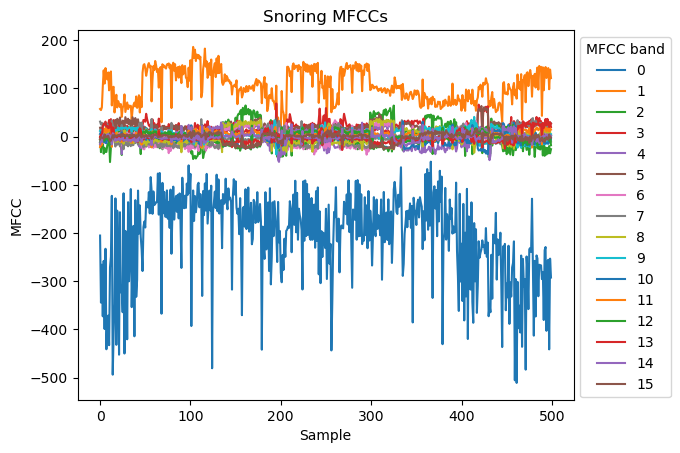

In [51]:
snore_df.plot()
plt.title('Snoring MFCCs')
plt.xlabel("Sample")
plt.ylabel("MFCC")
plt.legend(title='MFCC band', bbox_to_anchor=(1, 1))
plt.show()

As observed in our visualizations, the second band (band index 1) have the highest energy amongst the 16 MFCC bands. There is also a large variation in band 0.

In [39]:
features_0 = []
for file in os.listdir('data/0'):
    features_0.append(features_extractor(os.path.join('data','0',file)))

In [40]:
not_snore_df = pd.DataFrame(features_0)

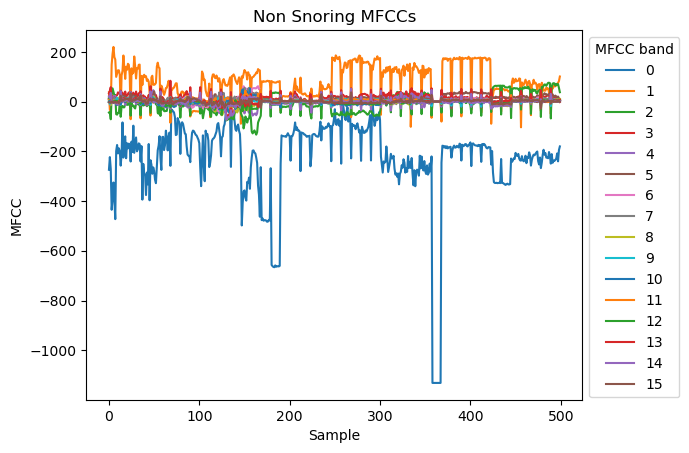

In [52]:
not_snore_df.plot()
plt.title('Non Snoring MFCCs')
plt.xlabel("Sample")
plt.ylabel("MFCC")
plt.legend(title='MFCC band', bbox_to_anchor=(1, 1))
plt.show()

The outliers between samples 350 and 400 are samples of silence thus the low values.

The distributions of MFCCs are quite different especially for MFCC band 1.
Let's compare them directly.

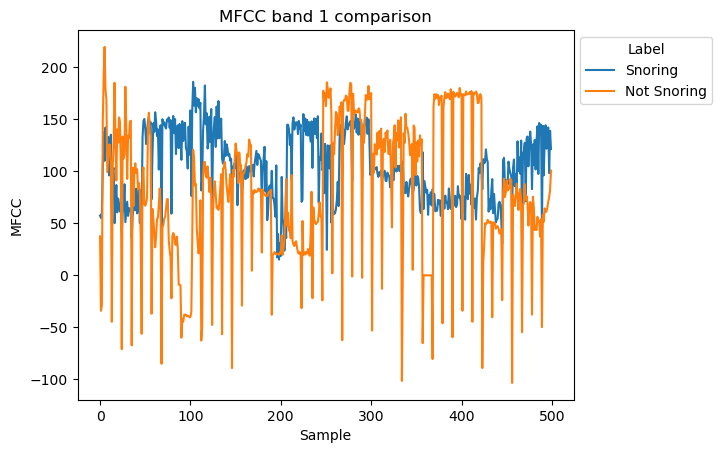

In [58]:
snore_df[1].plot()
not_snore_df[1].plot()
plt.title('MFCC band 1 comparison')
plt.xlabel("Sample")
plt.ylabel("MFCC")
plt.legend(title='Label',labels=['Snoring','Not Snoring'], bbox_to_anchor=(1, 1))
plt.show()

We can see that the variation for non-snoring in MFCC band 1 is a lot more than snoring. This would mean that this feature would be significant in differentating between snoring and not snoring.

In the next notebook, we will extract the MFCCs for every clip and shape them to fit our models.